In [1]:
__author__ = "Leandro Candau Sánchez de Ybargüen"

# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, concatenate, Input, Dropout, Lambda
from keras.callbacks import EarlyStopping
from keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
# Use Kaggle API to download this PanNuke dataset sample from Kaggle: https://www.kaggle.com/datasets/andrewmvd/cancer-inst-segmentation-and-classification
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/cancer-inst-segmentation-and-classification")

print("Path to dataset files:", path)

/Users/candau/tfm/unet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/candau/.cache/kagglehub/datasets/andrewmvd/cancer-inst-segmentation-and-classification/versions/4


## Loading the dataset

In [3]:
# Lets load the input dataset chosen, a subset of the PanNuke cancer segmentation dataset. https://link.springer.com/chapter/10.1007/978-3-030-23937-4_2
# This dataset has 2656 sample 256x256 RGB image patches, compossed of a pieces of Whole Slide Images (WSI).
# Along the images we have instance segmentation masks, an array of 6 channel instance-wise masks (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 6: Background)
# Finally we have the types, repressenting the tissue type that a given path was extracted from.
images = np.load(f'{path}/Part 1/Images/images.npy')
masks = np.load(f'{path}/Part 1/Masks/masks.npy')
types = np.load(f'{path}/Part 1/Images/types.npy')

In [4]:
# First lets take a look at what we've loaded from the dataset
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Types shape: {types.shape}")

Images shape: (2656, 256, 256, 3)
Masks shape: (2656, 256, 256, 6)
Types shape: (2656,)


In [5]:
# Check how many types of tissues does the dataset have
unique_types = set(types)
unique_types

{np.str_('Adrenal_gland'),
 np.str_('Bile-duct'),
 np.str_('Bladder'),
 np.str_('Breast'),
 np.str_('Cervix'),
 np.str_('Colon'),
 np.str_('Esophagus'),
 np.str_('HeadNeck'),
 np.str_('Kidney'),
 np.str_('Liver'),
 np.str_('Lung'),
 np.str_('Ovarian'),
 np.str_('Pancreatic'),
 np.str_('Prostate'),
 np.str_('Skin'),
 np.str_('Stomach'),
 np.str_('Testis'),
 np.str_('Thyroid'),
 np.str_('Uterus')}

## Visualization of a sample from the dataset

In [21]:
# Define a function to allow us to visualize an image from the dataset next to its masks and the type of tissue
def visualize_image(image, mask, index):
    # Set up the figure
    plt.figure(figsize=(12, 4))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image[index])
    plt.title(f"{types[index]}")
    plt.axis("off")  # Hide axes for a cleaner look

    # Plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.argmax(mask[index], axis=-1), cmap="viridis")
    plt.title(f"mask for {types[index]}")
    plt.axis("off")

    plt.tight_layout()

    plt.show()


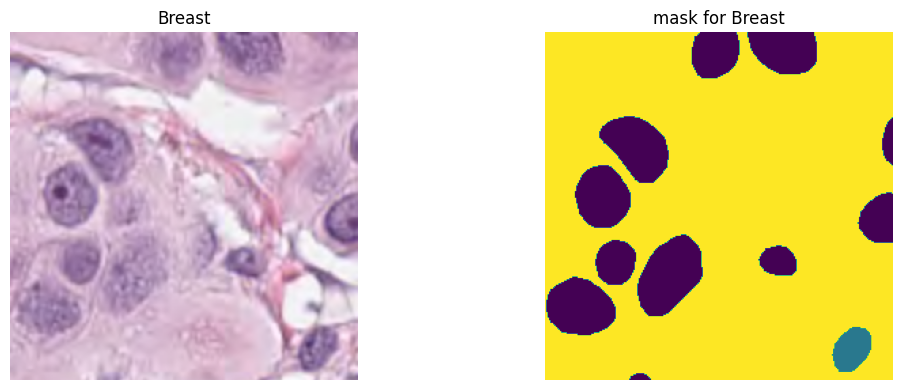

In [22]:
plt_images=images.astype('int32')
visualize_image(plt_images,masks,np.random.randint(0, images.shape[0]))

## Define the model

### U-Net model
U-Net: Convolutional Networks for Biomedical Image Segmentation - 2015
https://arxiv.org/pdf/1505.04597

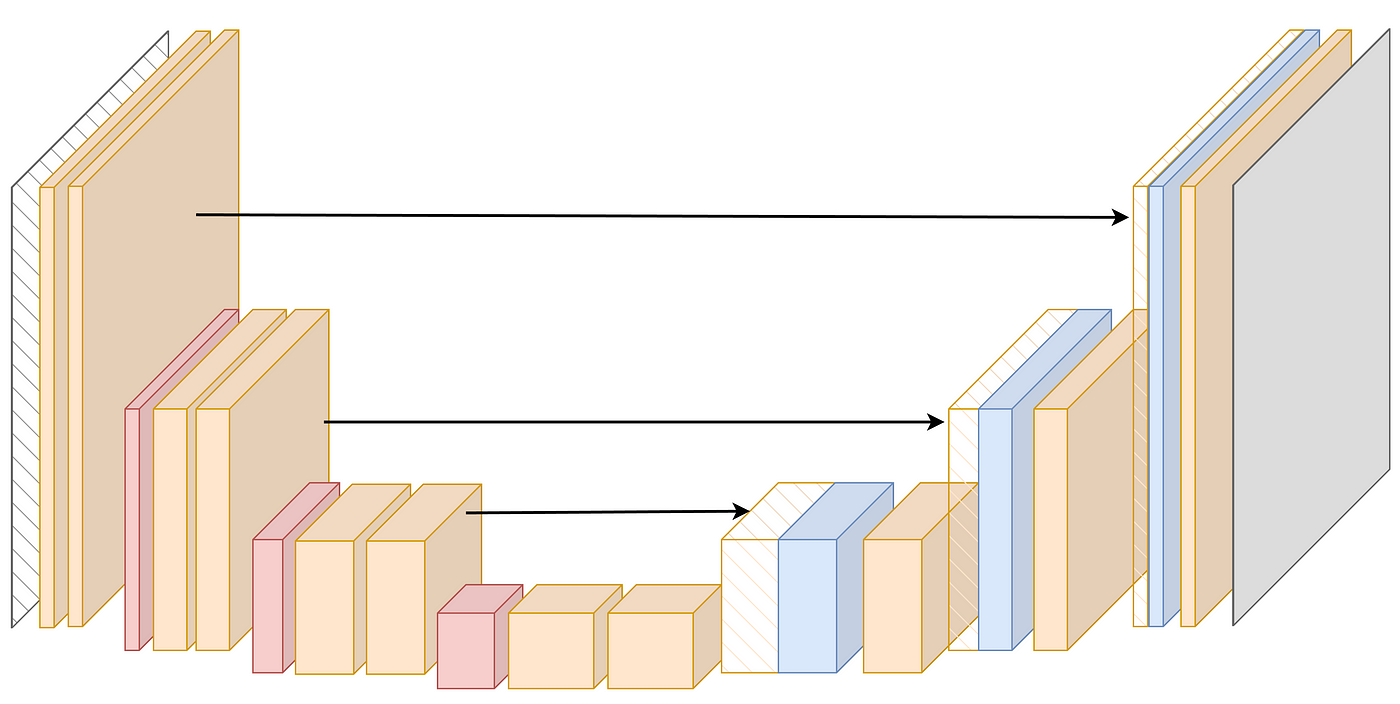

In [9]:
def mean_iou(y_true, y_pred, num_classes=6):
    """
    Computes the mean IoU for one-hot encoded masks.
    
    Parameters:
    - y_true: Ground truth one-hot encoded masks, shape (batch_size, height, width, num_classes)
    - y_pred: Predicted one-hot encoded masks, shape (batch_size, height, width, num_classes)
    - num_classes: Number of segmentation classes
    
    Returns:
    - mean IoU score across all classes
    """
    # Convert one-hot encoded predictions and labels to class indices
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    
    iou_scores = []
    
    for i in range(num_classes):
        # Create masks for the current class
        true_class = tf.equal(y_true, i)
        pred_class = tf.equal(y_pred, i)
        
        # Calculate intersection and union
        intersection = tf.reduce_sum(tf.cast(true_class & pred_class, tf.float32))
        union = tf.reduce_sum(tf.cast(true_class | pred_class, tf.float32))
        
        # Avoid division by zero; only add IoU if the union is greater than zero
        iou = tf.math.divide_no_nan(intersection, union)
        iou_scores.append(iou)
    
    # Compute mean IoU across all classes
    mean_iou = tf.reduce_mean(tf.stack(iou_scores))
    
    # Return the result of the MeanIoU calculation
    return mean_iou

In [10]:
# In this instance we will try to train an image segmentation model using U-Net as the model
def build_u_net(input_size=(256, 256, 3), dropout_rate=0.5):
    # Based on:
    # - https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
    # - https://github.com/bnsreenu/python_for_microscopists/blob/master/074-Defining%20U-net%20in%20Python%20using%20Keras.py

    inputs = Input(input_size)
    
    # Normalize the input
    normalized = Lambda(lambda x: x / 255.0)(inputs)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(normalized)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(dropout_rate)(pool1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(dropout_rate)(pool2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(dropout_rate)(pool3)
    
    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(dropout_rate)(conv4)
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(drop4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    outputs = Conv2D(6, 1, activation='softmax')(conv7)  # 6 classes output

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', mean_iou])

    return model

In [11]:
model = build_u_net(input_size=(256, 256, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat

 Total params: 7,794,502 (29.73 MB)

 Trainable params: 7,788,870 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

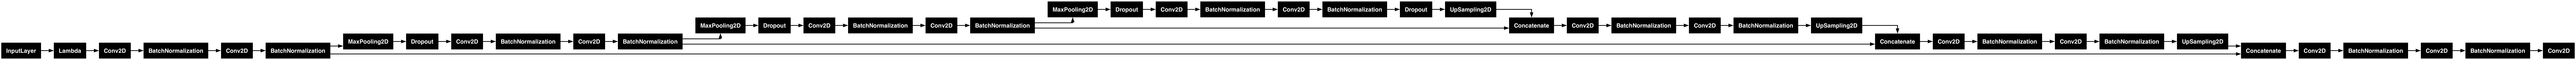

In [12]:
keras.utils.plot_model(model, rankdir="LR")
# keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Trainning the model

In [13]:
# Divide the dataset into trainning (70%), validation (10%) and tests (20%)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, random_state=42)

In [14]:
print(f"X trainning samples: {X_train.shape}")
print(f"X validation samples: {X_val.shape}")
print(f"X testing samples: {X_test.shape}")
print(f"y trainning samples: {y_train.shape}")
print(f"y validation samples: {y_val.shape}")
print(f"y testing samples: {y_test.shape}")

X trainning samples: (1859, 256, 256, 3)
X validation samples: (270, 256, 256, 3)
X testing samples: (527, 256, 256, 3)
y trainning samples: (1859, 256, 256, 6)
y validation samples: (270, 256, 256, 6)
y testing samples: (527, 256, 256, 6)


In [15]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # Monitor the validation set accuracy
    mode='max',                 # Consider higher validation accuracy as better
    patience=2,                 # Wait for a single epoch of no improvement before stopping
    restore_best_weights=True   # Restore weights from the best epoch with the highest validation accuracy
)

In [16]:
# Train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks=[early_stopping]
)

Epoch 1/10


/Users/candau/tfm/unet/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 1992s 34s/step - accuracy: 0.4258 - loss: 184.3358 - mean_iou: 0.1112 - val_accuracy: 0.0621 - val_loss: 78.8800 - val_mean_iou: 0.0267
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1380s 23s/step - accuracy: 0.7372 - loss: 247.6812 - mean_iou: 0.1978 - val_accuracy: 0.0994 - val_loss: 138.2433 - val_mean_iou: 0.0164
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1387s 24s/step - accuracy: 0.7428 - loss: 340.8585 - mean_iou: 0.1944 - val_accuracy: 0.8192 - val_loss: 573.5865 - val_mean_iou: 0.1376
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1396s 24s/step - accuracy: 0.7481 - loss: 344.2512 - mean_iou: 0.1970 - val_accuracy: 0.1795 - val_loss: 225.4312 - val_mean_iou: 0.0417
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1391s 24s/step - accuracy: 0.5148 - loss: 413.1820 - mean_iou: 0.1477 - val_accuracy: 0.0754 - val_loss: 408.6965 - val_mean_iou: 0.0300


In [17]:
# Evaluate the model
test_loss, test_acc, test_iou = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}, Test IoU: {test_iou}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.8139 - loss: 578.7556 - mean_iou: 0.1363
Test loss: 582.8758544921875, Test accuracy: 0.8096103668212891, Test IoU: 0.13551799952983856


In [18]:
# Finally, save the trainned model for latter use
model.save("my_unet_model_2.keras")

## Result visualization

In [19]:
def visualize_single_prediction(model, image, mask):
    """
    Visualizes a single image with its predicted mask and true mask.
    
    Parameters:
    - model: Trained Keras model for segmentation.
    - image: Numpy array of the image to be segmented, shape (256, 256, 3).
    - mask: Numpy array of the ground truth mask, shape (256, 256, 6).
    """
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Predict on a single image

    # Set up the figure
    plt.figure(figsize=(12, 4))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Plot the predicted mask (argmax to get the class with highest probability)
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="viridis")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Plot the true mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(mask, axis=-1), cmap="viridis")
    plt.title("True Mask")
    plt.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


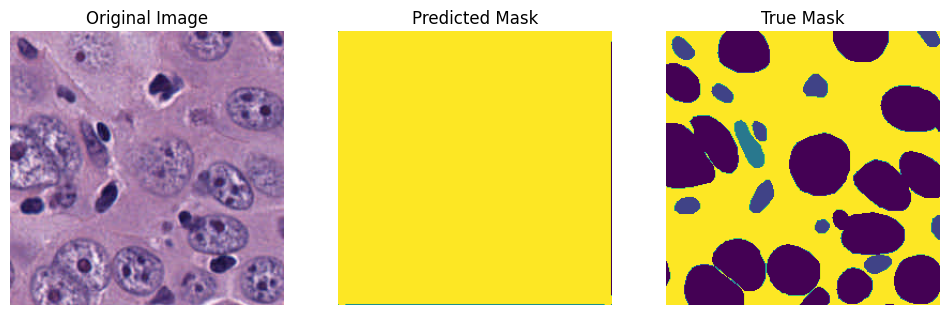

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


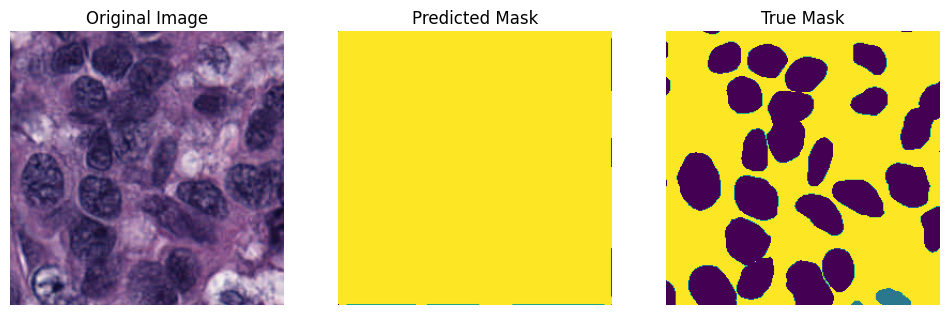

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


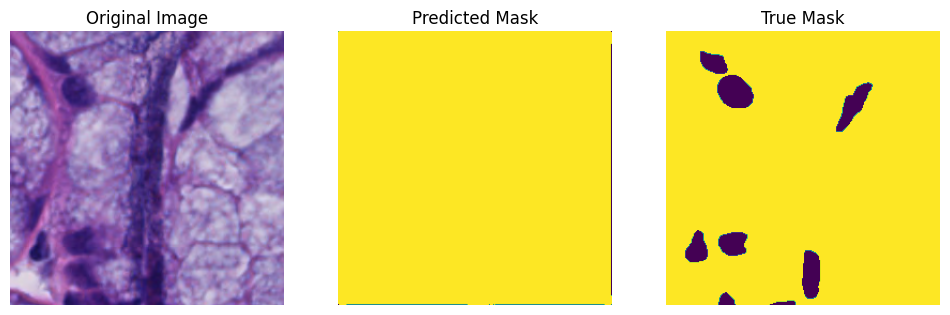

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


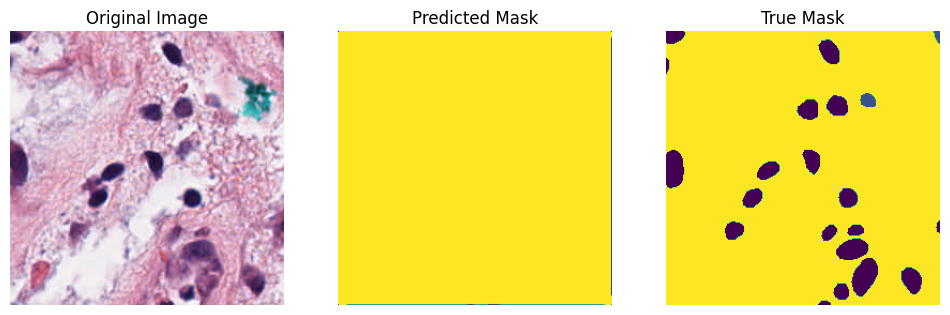

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


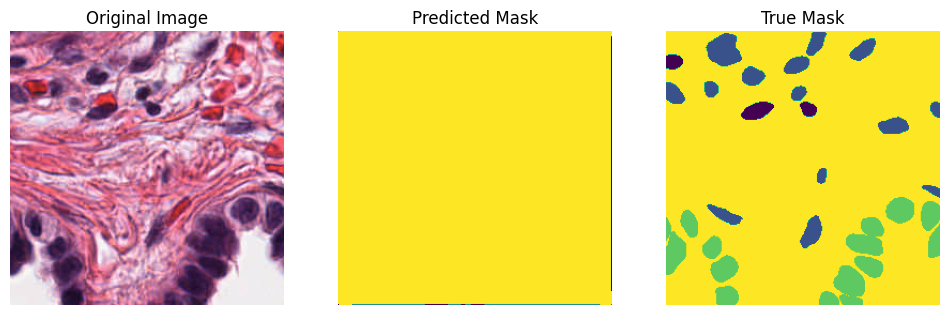

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


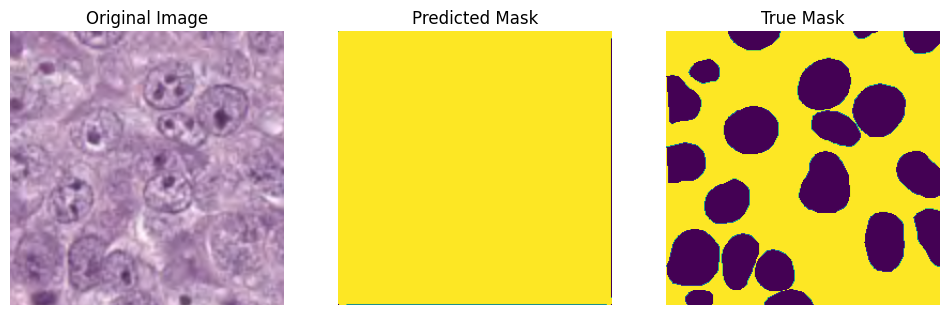

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


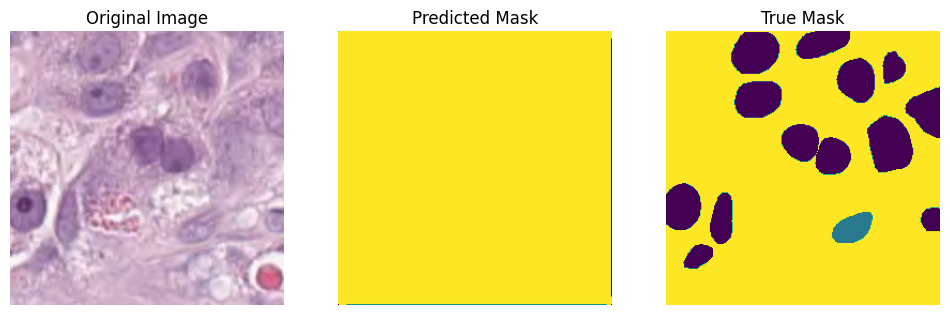

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


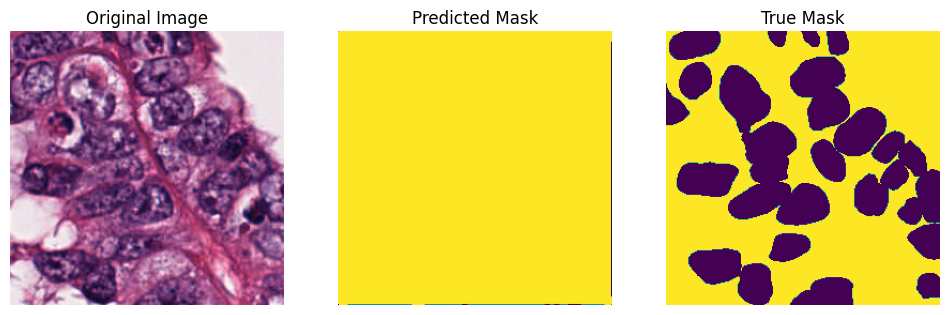

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


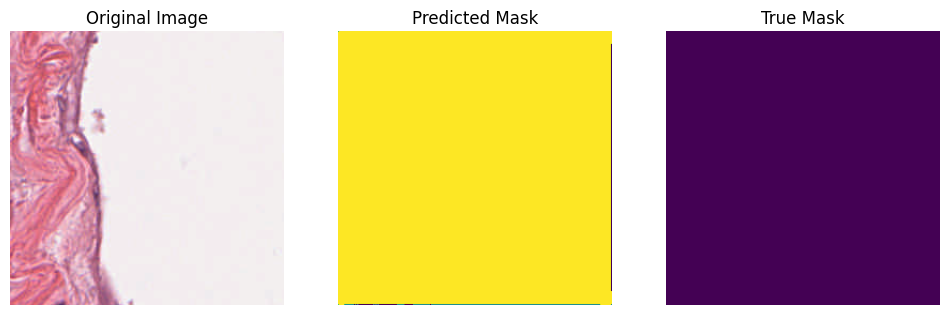

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


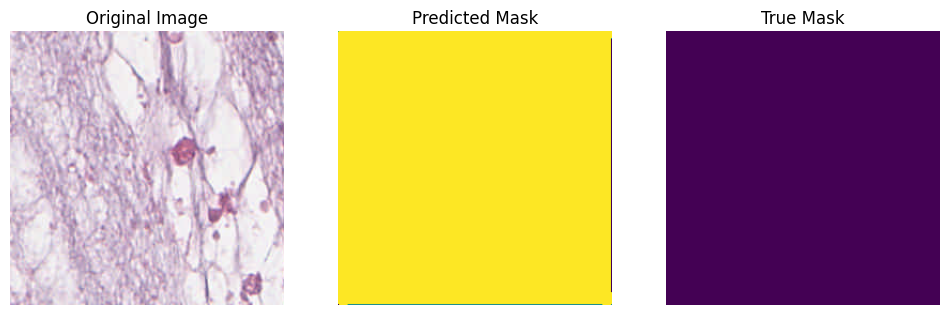

In [20]:
# Visualize 10 random samples from the test dataset
for _ in range(10):
    # Select a random index
    index = np.random.randint(0, X_test.shape[0])

    # Get the image and true mask
    image = X_test[index]
    true_mask = y_test[index]

    # Visualize the image, predicted mask, and true mask
    visualize_single_prediction(model, image, true_mask)